# Project: Geometric Brownian Motion (GBM) Models and Stylized Facts
Geometric Brownian motion (GBM) is widely used as a pricing model. However, whether GBM replicates many of the statistical properties of actual pricing and return data is unclear. 
* These properties, referred to as _stylized facts_ have been observed for decades, dating back to early work by [Mandelbrot](https://en.wikipedia.org/wiki/Benoit_Mandelbrot) and later in several studies by [Rama Cont](http://rama.cont.perso.math.cnrs.fr/pdf/empirical.pdf) and more recently by [Ratliff-Crain et al.](https://arxiv.org/abs/2311.07738) who reviewed the 11 original stylized facts proposed by [Cont](http://rama.cont.perso.math.cnrs.fr/pdf/empirical.pdf) with newer data.

## Learning objectives
In this project, students will examine a few of the statistical properties (stylized facts) of return data and explore how well geometric Brownian motion models replicate these properties. 

* __Prerequisite__: Load and clean the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) between `01-03-2018` and `12-29-2023`.
* __Objective 1__: Are the returns in dataset $\mathcal{D}$ actually Laplace distributed?
    * `TODO`: Estimate the return data for firms in dataset $\mathcal{D}$
    * `TODO`: Classify the returns of firm $i$ as $c_{i}\in\left\{\text{normal},\text{laplace},\text{undefined}\right\}$
* __Objective 2__: Does geometric Brownian motion replicate common stylized facts?
    * `TODO`: Load the $\left(\hat{\mu},\hat{\sigma}\right)$ values from the previous example
    * `TODO`: Compute the return distribution predicted by a GBM model analytical solution
    * `TODO`: Test the autocorrelation of GBM model returns
    * `TODO`: Test the volatility clustering of GBM model returns

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. 
* We load the `orignal_dataset` by calling the `MyMarketDataSet()` function and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ is stored in the `dataset` variable, where the dataset $\mathcal{D}$ has data for $\mathcal{L}$ firms, held in the `list_of_all_firms` variable.

In [2]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Then, get a list of firms that we have in the cleaned-up `dataset` and save it in the `list_of_all_firms` array (we sort these alphabetically):

In [5]:
list_of_all_firms = keys(dataset) |> collect |> sort;

Finally, we set some constant values that are used throughout the study. In particular, the value of $\Delta{t}$ holds the time step that we'll use (see below for a discussion of the value), and we'll specify the number of trading days to simulate in the `T` variable:

In [6]:
Δt = (1.0/252.0);
T = 48;
all_range = range(1,stop=maximum_number_trading_days,step=1) |> collect;

## Objective 1: Are the returns in dataset $\mathcal{D}$ Laplace distributed?
One of the central stylized facts is that return distributions have `fat tails,` i.e., the density of the returns near zero is smaller than a normal distribution, with more density on the tails of the distribution. 
* In the example for this module, we showed that only a small fraction of returns actually followed a normal distribution. However, while we suggested an alternative `Laplace` distribution for most firms in dataset $\mathcal{D}$, we did not quantitatively test this assertion.

Let's develop a procedure based on the [Anderson–Darling test](https://en.wikipedia.org/wiki/Anderson–Darling_test) and [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) exported by the [HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl) to estimate which firms in the dataset $\mathcal{D}$ follow a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution)

### TODO: Estimate the return data for firms in dataset $\mathcal{D}$.
Compute the log growth rates for the firms in the `list_of_all_firms` $\mathcal{L}$ using the `log_return_matrix(...)` function.
* The `log_return_matrix(...)` takes `dataset` $\mathcal{D}$ and a list of firms $\mathcal{L}$ and computes the growth rate values for each firm as a function of time. The data is returned as a $\mathcal{D}_{i}\times\dim\mathcal{L}$ array (time on the rows, firm $i$ on the columns). We store the data in the `log_growth_array` variable:

In [7]:
log_growth_array = log_return_matrix(dataset, list_of_all_firms);

### TODO: Classify the returns of firm $i$ as $c_{i}\in\left\{\text{normal},\text{laplace},\text{undefined}\right\}$
Suppose we define the class set $\mathcal{C}\equiv\left\{\text{normal},\text{laplace},\text{undefined}\right\}$ to describe the possible types of returns. Classify the shape of the returns for each of the firms in the `dataset` $\mathcal{D}$, where for each firm $i$ we compute a classification $c_{i}\in\left\{\text{normal},\text{laplace},\text{undefined}\right\}$. For each statistical test, use a `pvalue = 0.0001` cutoff.
* `Normal`: Test for normality of the return for firm $i$ using a one-sample [Anderson–Darling test](https://en.wikipedia.org/wiki/Anderson–Darling_test).
* `Laplace`: If the return for firm $i$ is `NOT` normal, use a one-sample [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) and a one-sample [Anderson–Darling test](https://en.wikipedia.org/wiki/Anderson–Darling_test) to determine if the return for firm $i$ follows a `Laplace` distribution. 
* `Undefined`: If both the tests fail, classify firm $i$ as `undefined`.

In [8]:
return_classification_dictionary = Dict{String, Symbol}();
p_value_cutoff = 0.00001;
for i ∈ eachindex(list_of_all_firms)
    
    ticker = list_of_all_firms[i];
    samples = log_growth_array[:,i];
    
    d_normal = fit_mle(Normal, samples)
    d_laplace = fit_mle(Laplace, samples)

    AD_test_result = OneSampleADTest(samples,d_normal) |> pvalue
    if (AD_test_result > p_value_cutoff) # support H0
        return_classification_dictionary[ticker] = :normal
    else
        KS_test_result_laplace = ExactOneSampleKSTest(samples, d_laplace) |> pvalue
        AD_test_result_laplace = OneSampleADTest(samples,d_laplace) |> pvalue
        if (KS_test_result_laplace > p_value_cutoff && AD_test_result_laplace > p_value_cutoff)
            return_classification_dictionary[ticker] = :laplace
        else
            return_classification_dictionary[ticker] = :undefined
        end
    end
end
return_classification_dictionary;

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/r322N/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/r322N/src/kolmogorov_smirnov.jl:68


#### What is the fraction of `normal`, `laplace` or `undefined`?

In [9]:
fraction_normal = findall(x->x==:normal, return_classification_dictionary) |> length |> 
    x -> x/length(list_of_all_firms) |> x-> round(x,digits=3) |> x-> *(x,100.0)
println("Approximately $(fraction_normal)% of the firms in the dataset have Normally distributed returns")

Approximately 8.3% of the firms in the dataset have Normally distributed returns


In [10]:
fraction_laplace = findall(x->x==:laplace, return_classification_dictionary) |> length |> 
    x -> x/length(list_of_all_firms) |> x-> round(x,digits=3) |> x-> *(x,100.0)
println("Approximately $(fraction_laplace)% of the firms in the dataset have Laplace distributed returns")

Approximately 91.7% of the firms in the dataset have Laplace distributed returns


In [11]:
fraction_undefined = findall(x->x==:undefined, return_classification_dictionary) |> length |> 
    x -> x/length(list_of_all_firms) |> x-> round(x,digits=3) |> x-> *(x,100.0)
println("Approximately $(fraction_undefined)% of the firms in the dataset have undefined returned distributions")

Approximately 0.0% of the firms in the dataset have undefined returned distributions


## Objective 2: Does geometric Brownian motion replicate common stylized facts?

### TODO: Load the $\left(\hat{\mu},\hat{\sigma}\right)$ values from the previous example

In [12]:
parameters_df = CSV.read(joinpath(_PATH_TO_DATA,"Parameters-SP500-2018-2023.csv"), DataFrame);

In [13]:
SPY_parameters = findfirst(x->x=="SPY", parameters_df[:,:ticker]) |> i-> parameters_df[i,:]

Row,ticker,drift,volatility
,String7,Float64,Float64
377,SPY,0.100555,0.109962


### TODO: Compute the return distribution predicted by a GBM model
From the analytical solution of the geometric Brownian motion (GBM) equation, we can see that GBM will _not_ admit Laplace distributed returns, i.e., the returns will follow a normal distribution. The return for a GBM model is given by:
$$
\begin{equation}
r_{t,\circ}\equiv\ln\left(\frac{S_{t}}{S_{\circ}}\right) = \Biggl[\left(\mu-\frac{\sigma^{2}}{2}\right)\Delta{t} + (\sigma\sqrt{\Delta{t}})\cdot{Z_{t}(0,1)}\Biggr]
\end{equation}
$$
where $\Delta{t}=t - t_{\circ}$. This expression is a normal distribution with mean $\left(\mu-\frac{\sigma^{2}}{2}\right)\Delta{t}$ and variance $\sigma^{2}\Delta{t}$. Let's show this numerically using data for `SPY`.

In [14]:
μ̂ = SPY_parameters[:drift];
σ̂ = SPY_parameters[:volatility];

In [15]:
return_analytical_model = Normal((μ̂ - (σ̂^2)/2) ,σ̂)

Normal{Float64}(μ=0.09450899694384213, σ=0.10996151193800309)

Assume we start on the first trading day of `2023` and simulate until the end of `2023`. Get the data for `SPY` from the `dataset` using the [filter function from the DataFrame package](https://juliadatascience.io/filter_subset). The selection condition we'll use is to find `:timestamps` after `Jan 01, 2023`:

In [16]:
SPY_dataset = dataset["SPY"] |> x-> filter(:timestamp => y -> y ≥ Date(2023,01,01), x); 

In [17]:
nrow(SPY_dataset)

250

In [18]:
model = build(MyGeometricBrownianMotionEquityModel, (
            μ = μ̂, σ = σ̂ ));

number_of_samples = 5000;
Sₒ = SPY_dataset[1, :volume_weighted_average_price];
T₁ = 0*Δt
T₂ = (nrow(SPY_dataset)-1)*Δt
X = VLQuantitativeFinancePackage.sample(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = number_of_samples);

In [19]:
size(X)

(250, 5001)

In [20]:
return_numerical_model = Array{Float64,1}()
for i ∈ 1:number_of_samples
    Sₒ = X[1,i+1];
    S₁ = X[end,i+1];
    r = log(S₁/Sₒ)
    push!(return_numerical_model,r)
end

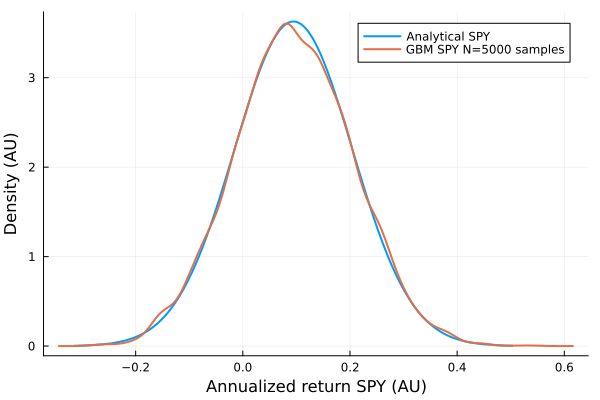

In [21]:
plot(return_analytical_model, label="Analytical SPY", lw=2)
density!(return_numerical_model, label="GBM SPY N=$(number_of_samples) samples",lw=2)
xlabel!("Annualized return SPY (AU)",fontsize=18)
ylabel!("Density (AU)", fontsize=18)

### TODO: Test the autocorrelation of GBM model returns

In [28]:
annualized_daily_growth_array_GBM_SPY = Array{Float64,2}(undef, nrow(SPY_dataset)-1, number_of_samples)
for i ∈ 1:number_of_samples
    for k ∈ 2:nrow(SPY_dataset)
        Sₒ = X[k-1,i+1];
        S₁ = X[k,i+1];
        annualized_daily_growth_array_GBM_SPY[k-1,i] = (1/Δt)*log(S₁/Sₒ);
    end
end
annualized_daily_growth_array_GBM_SPY;

In [23]:
annualized_daily_return_data_SPY = log_return_matrix(Dict("SPY"=>SPY_dataset), ["SPY"], testfirm="SPY");

In [24]:
L = length(annualized_daily_return_data_SPY);
τ  = range(0,step=1,stop=(L-1));
AC_model = autocor(annualized_daily_growth_array_GBM_SPY[:,1], τ); # function provided by the StatsBase package
AC_data = autocor(annualized_daily_return_data_SPY, τ); # function provided by the StatsBase package

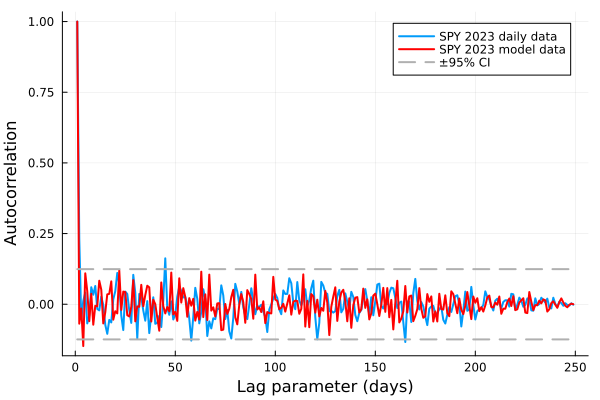

In [25]:
Δ = 1.96/sqrt(L)
plot(AC_data, lw=2, label="SPY 2023 daily data")
plot!(AC_model, lw=2, c=:red,label="SPY 2023 model data")
plot!(Δ*ones(L),lw=2,c=:gray69,ls=:dash, label="±95% CI")
plot!(-Δ*ones(L),lw=2,c=:gray69,ls=:dash, label="")
xlabel!("Lag parameter (days)",fontsize=18)
ylabel!("Autocorrelation", fontsize=18)

### TODO: Test the volatility clustering of GBM model returns

In [26]:
AC_model_abs = autocor(abs.(annualized_daily_growth_array_GBM_SPY[:,1]), τ); # function provided by the StatsBase package
AC_data_abs = autocor(abs.(annualized_daily_return_data_SPY), τ); # function provided by the StatsBase package

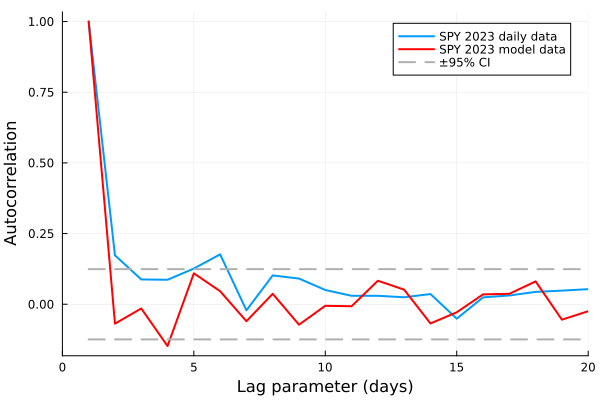

In [27]:
Δ = 1.96/sqrt(L)
plot(AC_data_abs, lw=2, label="SPY 2023 daily data", xlims=(0,100))
plot!(AC_model_abs, lw=2, c=:red,label="SPY 2023 model data")
plot!(Δ*ones(L),lw=2,c=:gray69,ls=:dash, label="±95% CI")
plot!(-Δ*ones(L),lw=2,c=:gray69,ls=:dash, label="")
xlabel!("Lag parameter (days)",fontsize=18)
ylabel!("Autocorrelation", fontsize=18)

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.